In [1]:
class FeedForwardNN:
    def __init__(
        self,
        epochs,
        noOfHL,
        NeuronsPL,
        noOfClass,
        X_train,
        y_train,
        x_test,
        y_test,
        optimizer,
        activationfunction,
        learningRate,
        batchSize,
        initialize,
        lossfunction,
        gamma=0.9,
        Beta=0.5,
        epsilon=0.0001
    ):
        self.noOfHL=noOfHL
        self.ListOfNeuronsPL=NeuronsPL
        self.noOfClass=noOfClass
        self.x_train=x_train
        self.y_train=y_train
        self.x_test=x_test
        self.y_test=y_test
        self.activationfunction=activationfunction
        self.epochs=epochs
        self.learningRate=learningRate
        self.batchSize=batchSize
        self.Optimizers={
            "SGD": self._sgd,
            "MGD": self._mgd,
            "NAG": self._nag,
            "RMSPROP": self._rmsProp,
            "ADAM": self._adam,
            "NADAM": self._nadam,
        }
        self.initialize=initialize
        #initialise the initial weights matrix which contains noOfHiddenLayers+1  weight matrices
        self.W=self.initialize_weights()
        #initialise the initial biases matrix which contains noOfHiddenLayers+1  biases matrices
        self.b=self.initialize_biases()
        self.lossfunction=lossfunction
        self.optimizer=self.Optimizers[optimizer]
        self.gamma=gamma
        self.beta=Beta
        self.epsilon=epsilon

    #returns the weight matrix for the initial configuration, we have used 1 indexing for weights
    def initialize_weights(self):
        weight=[0]*(self.noOfHL+2)
        if(initialize=="RANDOM"):
            for i in range(self.noOfHL+1):
                if(i==0):
                    continue
                if(i==1):
                    w=np.random.uniform(-1, 1, size=(self.ListOfNeuronsPL[i-1],self.x_train.shape[1]))
                else:
                    w=np.random.uniform(-1,1,size=(self.ListOfNeuronsPL[i-1],self.ListOfNeuronsPL[i-2]))
                weight[i]=w
            w=np.random.uniform(-1,1,size=(self.noOfClass,self.ListOfNeuronsPL[self.noOfHL-1]))
            weight[self.noOfHL+1]=w

        #initialising the weights with xavier
        if(initialize=="XAVIER"):
            for i in range(self.noOfHL+1):
                if(i==0):
                    continue
                if(i==1):
                    ni=self.ListOfNeuronsPL[i-1]
                    no=self.x_train.shape[1]
                    w=np.random.uniform(-(6/(ni+no))**0.5,(6/(ni+no))**0.5,size=(ni,no))
                else:
                    ni=self.ListOfNeuronsPL[i-1]
                    no=self.ListOfNeuronsPL[i-2]
                    w=np.random.uniform(-(6/(ni+no))**0.5,(6/(ni+no))**0.5,size=(ni,no))
                weight[i]=w
            ni=self.noOfClass
            no=self.ListOfNeuronsPL[self.noOfHL-1]
            w=np.random.uniform(-(6/(ni+no))**0.5,(6/(ni+no))**0.5,size=(ni,no))
            weight[self.noOfHL+1]=w
        return weight
                    
    #returns the biases matrix for the initial configurtion, we have used 1 indexing for biases
    def initialize_biases(self):
        biases=[0]*(self.noOfHL+2)
        if(initialize=="XAVIER"):
            for i in range(self.noOfHL+1):
                if(i==0):
                    continue
                else:
                    b=np.random.uniform(-(6/(self.ListOfNeuronsPL[i-1]+1))**0.5,(6/(self.ListOfNeuronsPL[i-1]+1))**0.5,size=(self.ListOfNeuronsPL[i-1]))
                biases[i]=b
            b=np.random.uniform(-(6/(self.noOfClass+1))**0.5,(6/(self.noOfClass+1))**0.5,size=(self.noOfClass))
            biases[self.noOfHL+1]=b

        if(initialize=="NORMAL"):
            for i in range(self.noOfHL+1):
                if(i==0):
                    continue
                else:
                    b=np.random.uniform(-1, 1, size=(self.ListOfNeuronsPL[i-1]))
                biases[i]=b
            b=np.random.uniform(-1, 1, size=(self.noOfClass))
            biases[self.noOfHL+1]=b
        return biases
    
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    def tanh(self,x):
        return np.tanh(x)
    
    def sin(self,x):
        return np.sin(x)
    
    def relu(self,x):
        np.maximum(x,0)
        
    
    #returns softmax value of a variable x
    def softmax(self,x):
        x_max=np.max(x)
        exp_x=np.exp(x-x_max)
        sum_e=np.sum(exp_x)
        return exp_x/sum_e
    
    def activationFunc(self,A):
        A=np.array(A)
        if self.activationfunction=="SIGMOID":
            return self.sigmoid(A)
        if self.activationfunction=="RELU":
            return self.relu(A)
        if self.activationfunction=="TANH":
            return self.tanh(A)
        if self.activationfunction=="SIN":
            return self.sin(A)
    
    #calculates and returns the predicted values of y using the output Function
    def outputFunc(self,A):
        yhat=self.softmax(A)
        return yhat
        
    #calculates all the H,A and yhat in the forward propogation of backpropogation
    def forwardPropogation(self,x):
        L=self.noOfHL+1
        k=self.noOfClass
        H=[0]*(L)
        A=[0]*(L+1)
        H[0]=x
        for i in range(L-1):
            A[i+1]=self.b[i+1]+np.dot(self.W[i+1],H[i])
            H[i+1]=self.activationFunc(A[i+1])
        A[L]=self.b[L]+np.dot(self.W[L],H[L-1])
        yhat=self.outputFunc(A[L])
        yhat=np.array(yhat)
        return  H,A,yhat
    
    #derivative of loss wrt to activation of last layer if output function used is softmax
    def derivative_wrt_lossFunc(self,yhat,y_train,i):
        k=self.noOfClass
        e_l=np.zeros(k)
        e_l[y_train[i]]=1
        if self.lossfunction=="CROSS":
            return -1*(e_l-yhat)
        if self.lossfunction=="MSE":
            a=2*(yhat-e_l)
            b=np.multiply(yhat,(1-yhat))
            ans=(np.multiply(a,b)).astype(float)
            return ans
            
    
    #gradient of activation functions
    def cal_activationFunc_grad(self,As):
        g_dash=[]
        if self.activationfunction=="SIGMOID":
            for i in As:
                g_dash.append( self.sigmoid(i) * (1 - self.sigmoid(i) ) )
            return g_dash
        if self.activationfunction=="TANH":
            for i in As:
                g_dash.append( 1 - np.tanh(z) ** 2)
            return g_dash
        
    def backwardPropogation(self,i,Hs,As,yhat,y_train):
        W=self.W
        L=self.noOfHL+1
        weights_grad=[0]*(L+1)
        biases_grad=[0]*(L+1)
        activation_grad=[0]*(L+1)
        preactivation_grad=[0]*(L+1)
        activationFunc_grad=[]
        preactivation_grad[L]=self.derivative_wrt_lossFunc(yhat,y_train,i)
        for k in range(L+1)[::-1]:
            if(i==0):
                continue
            #gradient of loss wrt to weights at layer k
            weights_grad[k]=np.outer(preactivation_grad[k],np.transpose(Hs[k-1]))
#             print("weights_grad wrt loss at level {} is {}".format(k,type(weights_grad[k])))
            
            #gradient of loss wrt to biases at layer k
            biases_grad[k]=preactivation_grad[k]
#             print("baises_grad wrt loss at level {} is {}".format(k,biases_grad[k].shape))
            
            #for the next layer calculating gradient of loss wrt to activation
            activation_grad[k-1]=np.dot(np.transpose(W[k]),preactivation_grad[k])
#             print("activation_grad wrt loss at level {} is {}".format(k,activation_grad[k-1].shape))
            
            #calculate gradient of activation function wrt preactivation of previous layer
            if(k>1):
                activationFunc_grad=self.cal_activationFunc_grad(As[k-1])

                #for the next layer calculating gradient of loss wrt to preactivation
                preactivation_grad[k-1]=np.multiply(activation_grad[k-1],activationFunc_grad)
            
        return weights_grad,biases_grad
    
    def acc_grad(self,final_grad,f_g):
        L=self.noOfHL+1
        for i in range(L+1):
            if(i==0):
                continue
            final_grad[i]=final_grad[i]+f_g[i]
        return final_grad
    #update the parameters according to 
    def updateWeights(self,eta,weights_grad):
        L=self.noOfHL+1
        for i in range(L+1):
            if(i==0):
                continue
            self.W[i]=self.W[i]-(eta)*weights_grad[i]
        return
    
    def updateBiases(self,eta,biases_grad):
        L=self.noOfHL+1
        for i in range(L+1):
            if(i==0):
                continue
            self.b[i]=self.b[i]-(eta)*biases_grad[i]
        return
    
    #Loss Functions
    
    def crossEntropy(self,yhat,i):
        return -1*np.log(yhat[self.y_train[i]])
    
    def meanSquaredError(self,yhat,i):
        MSE=0
        for j in range(self.noOfClass):
            if j==self.y_train[i]:
                MSE+=(yhat[j]-1)**2
            else:
                MSE+=(yhat[j])**2
        return MSE/self.noOfClass
    
    def calculateLoss(self,yhat,i):
        if self.lossfunction=="MSE":
            return self.meanSquaredError(yhat,i)
        if self.lossfunction=="CROSS":
            return self.crossEntropy(yhat,i)
    
    
    def calculatetrainPredClasses(self):
        y_pred=[]
        for i in range(self.x_train.shape[0]):
            H,A,yhat=self.forwardPropogation(x_train[i])
            j=np.argmax(yhat)
            y_pred.append(j)
        y_pred=np.array(y_pred)
        return y_pred
    def calculatetestPredClasses(self):
        y_pred=[]
        for i in range(self.x_test.shape[0]):
            H,A,yhat=self.forwardPropogation(x_test[i])
            j=np.argmax(yhat)
            y_pred.append(j)
        y_pred=np.array(y_pred)
        return y_pred
            
    def calculatetrainAccuracy(self):
        y_pred=self.calculatetrainPredClasses()
        count=0;
        for i in range(y_train.shape[0]):
            if y_pred[i]==y_train[i]:
                count+=1
        return ((count/y_train.shape[0])*100)
    def calculatetestAccuracy(self):
        y_pred=self.calculatetestPredClasses()
        count=0;
        for i in range(y_test.shape[0]):
            if y_pred[i]==y_test[i]:
                count+=1
        return ((count/y_test.shape[0])*100)
        
        
    #Optimizers from here
    def _sgd(self):
        epochs=self.epochs
        L=self.noOfHL+1
        k=self.noOfClass
        x_train=self.x_train
        y_train=self.y_train
        eta=self.learningRate
        batchSize=self.batchSize
        deltaw=[]
        deltab=[]
        loss=[]
        trainingLoss=[]
        for epoch in range(epochs):
            loss=[]
            for i in range(x_train.shape[0]):
                if(i%batchSize==0):
                    if(i!=0):
                        #update the weights and biases
#                         self.updateWeights(eta,deltaw)
                        self.W[1:] = [self.W[i] - eta * deltaw[i] for i in range(1, L+1)]
#                         self.updateBiases(eta,deltab)
                        self.b[1:] = [self.b[i] - eta * deltab[i] for i in range(1, L+1)]
                    Hs,As,yhat=self.forwardPropogation(x_train[i])
                    w_g,b_g=self.backwardPropogation(i,Hs,As,yhat,y_train)
#                     if(i==0):
#                         deltaw=w_g
#                         deltab=b_g
                    deltaw=w_g
                    deltab=b_g
#                     else:
#                         deltaw=self.acc_grad(deltaw,w_g)
#                         deltab=self.acc_grad(deltab,b_g)
                else:
                    Hs,As,yhat=self.forwardPropogation(x_train[i])
                    w_g,b_g=self.backwardPropogation(i,Hs,As,yhat,y_train)
                    deltaw=self.acc_grad(deltaw,w_g)
                    deltab=self.acc_grad(deltab,b_g)
                    
                #append loss for this datapoint
                loss.append(self.calculateLoss(yhat,i))

                        #update the weights and biases
#                   self.updateWeights(eta,deltaw)
            self.W[1:] = [self.W[i] - eta * deltaw[i] for i in range(1, L+1)]
#                   self.updateBiases(eta,deltab)
            self.b[1:] = [self.b[i] - eta * deltab[i] for i in range(1, L+1)]
            trainingLoss.append(np.mean(loss))
            print("The loss after epoch:{} is {}".format(epoch,trainingLoss[epoch]))
#             plt.bar(range(len(predClasses)),predClasses)
#             plt.title('No of data per class')
#             plt.xlabel('Class')
#             plt.ylabel('count')
#             plt.show()
        accuracytrain=self.calculatetrainAccuracy()
        accuracytest=self.calculatetestAccuracy()
        return trainingLoss,accuracytrain,accuracytest
    def _mgd(self):
        Gamma=self.gamma
        epochs=self.epochs
        L=self.noOfHL+1
        k=self.noOfClass
        x_train=self.x_train
        y_train=self.y_train
        eta=self.learningRate
        batchSize=self.batchSize
        deltaw=[]
        deltab=[]
        prev_w=[0]*(L+1)
        prev_b=[0]*(L+1)
        loss=[]
        trainingLoss=[]
        t=0
        for epoch in range(epochs):
            loss=[]
            for i in range(x_train.shape[0]):
                if(i%batchSize==0):
                    if(i!=0):
                        #update the weights and biases
                        if t==0:
                            self.W[1:] = [self.W[i] - eta * deltaw[i]/batchSize for i in range(1, L+1)]
                            self.b[1:] = [self.b[i] - eta * deltab[i]/batchSize for i in range(1, L+1)]
                            prev_w[1:]=[eta*deltaw[i]/batchSize for i in range(1, L+1)]
                            prev_b[1:]=[eta*deltab[i]/batchSize for i in range(1, L+1)]
                            t=1
                        else:
                            self.W[1:] = [self.W[i] -  Gamma * prev_w[i] - eta * deltaw[i]/batchSize for i in range(1, L+1)]
                            self.b[1:] = [self.b[i] -  Gamma * prev_b[i] - eta * deltab[i]/batchSize for i in range(1, L+1)]
                            prev_w[1:]=[Gamma * prev_w[i] + eta*deltaw[i]/batchSize for i in range(1, L+1)]
                            prev_b[1:]=[Gamma * prev_b[i] + eta*deltab[i]/batchSize for i in range(1, L+1)]
                            
                    Hs,As,yhat=self.forwardPropogation(x_train[i])
                    w_g,b_g=self.backwardPropogation(i,Hs,As,yhat,y_train)
                    deltaw=w_g
                    deltab=b_g
#                     else:
#                         deltaw=self.acc_grad(deltaw,w_g)
#                         deltab=self.acc_grad(deltab,b_g)
                else:
                    Hs,As,yhat=self.forwardPropogation(x_train[i])
                    w_g,b_g=self.backwardPropogation(i,Hs,As,yhat,y_train)
                    deltaw=self.acc_grad(deltaw,w_g)
                    deltab=self.acc_grad(deltab,b_g)
                    
                #append loss for this datapoint
                loss.append(self.calculateLoss(yhat,i))

            self.W[1:] = [self.W[i] - Gamma * prev_w[i] - eta * deltaw[i]/batchSize for i in range(1, L+1)]
            self.b[1:] = [self.b[i] - Gamma * prev_b[i] - eta * deltab[i]/batchSize for i in range(1, L+1)]
            
            trainingLoss.append(np.mean(loss))
            print("The loss after epoch:{} is {}".format(epoch,trainingLoss[epoch]))
            
        accuracytrain=self.calculatetrainAccuracy()
        accuracytest=self.calculatetestAccuracy()
        return trainingLoss,accuracytrain,accuracytest
        
    def _nag(self):
        Gamma=self.gamma
        epochs=self.epochs
        L=self.noOfHL+1
        k=self.noOfClass
        x_train=self.x_train
        y_train=self.y_train
        eta=self.learningRate
        batchSize=self.batchSize
        deltaw=[]
        deltab=[]
        prev_w=[0]*(L+1)
        prev_b=[0]*(L+1)
        v_w=[0]*(L+1)
        v_b=[0]*(L+1)
        prev_w[1:]=[self.W[i] - self.W[i] for i in range(1, L+1)]
        prev_b[1:]=[self.b[i] - self.b[i] for i in range(1, L+1)]
        W_l=self.W
        b_l=self.b
        trainingLoss=[]
        t=0
        for epoch in range(epochs):
            loss=[]
            for i in range(x_train.shape[0]):
                if i!=0:
                    self.W=temp_w
                    self.b=temp_b
                if i%batchSize==0:
                    if t==0:
                        self.W[1:] = [self.W[i] - Gamma * prev_w[i] for i in range(1, L+1)]
                        self.b[1:] = [self.b[i] - Gamma * prev_b[i] for i in range(1, L+1)]

                        t=1
                    else:
                        v_w[1:] = [Gamma * prev_w[i] + eta * deltaw[i]/batchSize for i in range(1, L+1)]
                        v_b[1:] = [Gamma * prev_b[i] + eta * deltab[i]/batchSize for i in range(1, L+1)]
                        W_l[1:] = [W_l[i] - v_w[i] for i in range(1, L+1)]
                        b_l[1:] = [b_l[i] - v_b[i] for i in range(1, L+1)]
                        prev_w=v_w
                        prev_b=v_b
                        
                        #update params for lookahead
                        v_w[1:] = [Gamma * prev_w[i] for i in range(1, L+1)]
                        v_b[1:] = [Gamma * prev_b[i] for i in range(1, L+1)]
                        self.W[1:] = [self.W[i] - v_w[i] for i in range(1, L+1)]
                        self.b[1:] = [self.b[i] - v_b[i] for i in range(1, L+1)]
                        
                    Hs,As,yhat=self.forwardPropogation(x_train[i])
                    w_g,b_g=self.backwardPropogation(i,Hs,As,yhat,y_train)
                    deltaw=w_g
                    deltab=b_g
                        
                        
                else:
                    v_w[1:] = [Gamma * prev_w[i] for i in range(1, L+1)]
                    v_b[1:] = [Gamma * prev_b[i] for i in range(1, L+1)]
                    self.W[1:] = [self.W[i] - v_w[i] for i in range(1, L+1)]
                    self.b[1:] = [self.b[i] - v_b[i] for i in range(1, L+1)]
                    Hs,As,yhat=self.forwardPropogation(x_train[i])
                    w_g,b_g=self.backwardPropogation(i,Hs,As,yhat,y_train)
                    deltaw=self.acc_grad(deltaw,w_g)
                    deltab=self.acc_grad(deltab,b_g)
                temp_w=W_l
                temp_b=b_l
                self.W=W_l
                self.b=b_l
                
                loss.append(self.calculateLoss(yhat,i))
            v_w[1:] = [Gamma * prev_w[i] + eta * deltaw[i]/batchSize for i in range(1, L+1)]
            v_b[1:] = [Gamma * prev_b[i] + eta * deltab[i]/batchSize for i in range(1, L+1)]
            W_l[1:] = [W_l[i] - v_w[i] for i in range(1, L+1)]
            b_l[1:] = [b_l[i] - v_b[i] for i in range(1, L+1)]

            trainingLoss.append(np.mean(loss))
            print("The loss after epoch:{} is {}".format(epoch,trainingLoss[epoch]))
            
                        
        accuracytrain=self.calculatetrainAccuracy()
        accuracytest=self.calculatetestAccuracy()
        return trainingLoss,accuracytrain,accuracytest
    
    def _rmsProp(self):
        beta=self.beta
        L=self.noOfHL+1
        k=self.noOfClass
        x_train=self.x_train
        y_train=self.y_train
        eta=self.learningRate
        batchSize=self.batchSize
        v_w=[0]*(L+1)
        v_b=[0]*(L+1)
        deltaw=[]
        deltab=[]
        prev_w=[0]*(L+1)
        prev_b=[0]*(L+1)
        loss=[]
        trainingLoss=[]
        t=0
        for epoch in range(self.epochs):
            loss=[]
            for i in range(x_train.shape[0]):
                if(i%batchSize==0):
                    if(i!=0):
                        #update the weights and biases
                        if t==0:
                            v_w[1:]=[(1-beta) * deltaw[i]**2 for i in range(1, L+1)]
                            v_b[1:]=[(1-beta) * deltab[i]**2 for i in range(1, L+1)]
                            t=1
                        else:
                            v_w[1:]=[beta* prev_w[i] + (1-beta) * deltaw[i]**2 for i in range(1, L+1)]
                            v_b[1:]=[beta* prev_b[i] + (1-beta) * deltab[i]**2 for i in range(1, L+1)]
                            
                        self.W[1:] = [self.W[i] - (eta * deltaw[i]) / batchSize*(v_w[i]+epsilon)**0.5 for i in range(1, L+1)]
                        self.b[1:] = [self.b[i] - (eta * deltab[i]) / batchSize*(v_b[i]+epsilon)**0.5 for i in range(1, L+1)]
                        prev_w=v_w
                        prev_b=v_b
                            
                            
                    Hs,As,yhat=self.forwardPropogation(x_train[i])
                    w_g,b_g=self.backwardPropogation(i,Hs,As,yhat,y_train)
                    deltaw=w_g
                    deltab=b_g
                    
                else:
                    Hs,As,yhat=self.forwardPropogation(x_train[i])
                    w_g,b_g=self.backwardPropogation(i,Hs,As,yhat,y_train)
                    deltaw=self.acc_grad(deltaw,w_g)
                    deltab=self.acc_grad(deltab,b_g)
                    
                #append loss for this datapoint
                loss.append(self.calculateLoss(yhat,i))

            self.W[1:] = [self.W[i] - (eta * deltaw[i]) / batchSize*(v_w[i]+epsilon)**0.5 for i in range(1, L+1)]
            self.b[1:] = [self.b[i] - (eta * deltab[i]) / batchSize*(v_b[i]+epsilon)**0.5 for i in range(1, L+1)]
            
            trainingLoss.append(np.mean(loss))
            print("The loss after epoch:{} is {}".format(epoch,trainingLoss[epoch]))
            
        accuracytrain=self.calculatetrainAccuracy()
        accuracytest=self.calculatetestAccuracy()
        return trainingLoss,accuracytrain,accuracytest
    
    def _adam(self):
        return
        
    def _nadam(self):
        return
        

        
        
               
                
                
                
                
            
            
        

[3 3 3 ... 3 3 3]
The loss after epoch:0 is 0.6699157208270231
The loss after epoch:1 is 0.43385229298776157
The loss after epoch:2 is 0.3893781522538414
The loss after epoch:3 is 0.36389984457498564
The loss after epoch:4 is 0.3461628504928634
The loss after epoch:5 is 0.3323039920986533
The loss after epoch:6 is 0.32085788772127793
The loss after epoch:7 is 0.311619684941072
The loss after epoch:8 is 0.30367412572640334
The loss after epoch:9 is 0.29638589842305785
The loss after epoch:10 is 0.28996044649547564
The loss after epoch:11 is 0.2842486524030624
The loss after epoch:12 is 0.2788690429080941
The loss after epoch:13 is 0.27390883377008307
The loss after epoch:14 is 0.2692022384664853
The loss after epoch:15 is 0.2648349694195047
The loss after epoch:16 is 0.26073164531459314
The loss after epoch:17 is 0.25668110700853297
The loss after epoch:18 is 0.25282797409795005
The loss after epoch:19 is 0.24919702085512302
The loss after epoch:20 is 0.24592520625208883
The loss after 

<AxesSubplot:>

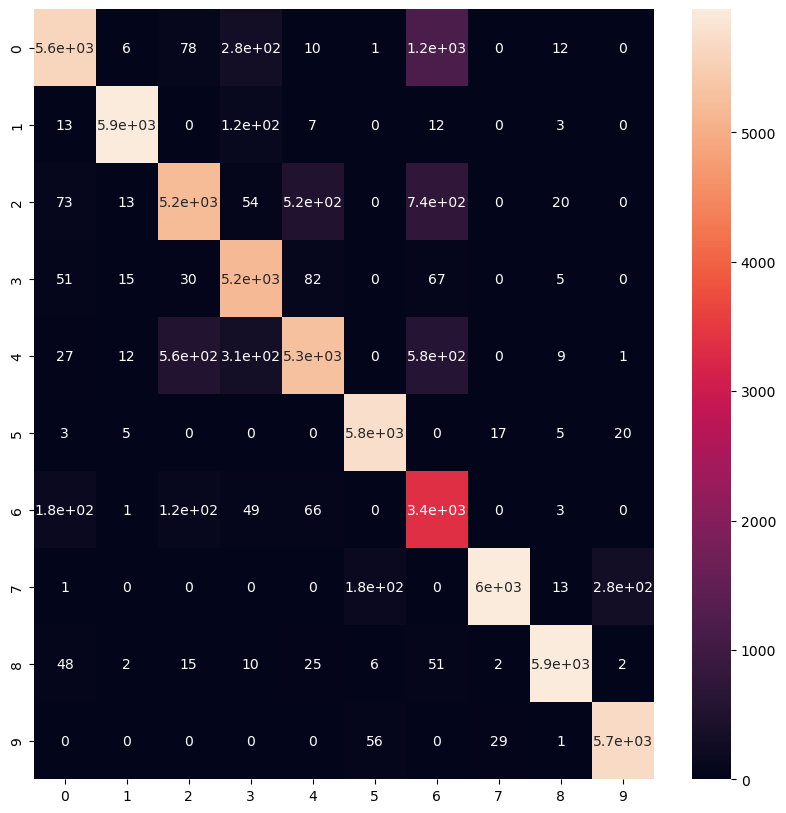

In [35]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.datasets import fashion_mnist

#importing the dataset from keras library
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# #one data image per label
# fig,ax=plt.subplots(nrows=10,figsize=(15,15))
# for i in range(10):
#     ax[i].set_title("\n class {} image".format(i))
#     ax[i].axis("off")
#     x=x_train[y_train==i]
#     ax[i].imshow(x[0,:,:],cmap="gray")

#normalizing the data between 0-1
x_train=x_train/255
x_train=x_train.astype(float);
x_test=x_test/255
x_test=x_test.astype(float);

#flattening the data points to 1D
x_train=x_train.reshape(60000,784)
x_test=x_test.reshape(10000,784)

#creating validation set
num_valid = int(0.1 * x_train.shape[0])  #using 10% of the data as validation test for the model and remaining for train
x_valid = x_train[:num_valid, :] 
y_valid = y_train[:num_valid] 
x_train = x_train[num_valid:, :] 
y_train = y_train[num_valid:]  

NeuronsPL=[32,32]
epochs=40
noOfHL=2
lossfunction="CROSS"
activationFunc="SIGMOID"
learningRate=0.1
batchSize=32
optimizer="NAG"
gamma=0.8
initialize="XAVIER"
Beta=0.7
epsilon=0.00001

#creating the object
FWNN=FeedForwardNN(epochs,noOfHL,NeuronsPL,10,x_train,y_train,x_test,y_test,optimizer,activationFunc,learningRate,batchSize,initialize,lossfunction,gamma,Beta,epsilon)

#predicting before training the model
y_pred=FWNN.calculatetrainPredClasses()
print(y_pred)

#training the model using sgd
loss,accuracytrain,accuracytest=FWNN.optimizer()
print("Accuracy of this model after {} epochs is training accuracy:{} and test accuracy:{}".format(epochs,accuracytrain,accuracytest))

y_pred=FWNN.calculatetrainPredClasses()
print(y_pred)
print(y_train)

#printing confusion matrix for visualization
plt.figure(figsize=(10,10))

# y_pred = np.array([np.argmax(FNNN.forwardPropogation(i)[2]) for i in range(len(x_train))])
sns.heatmap(confusion_matrix(y_pred.reshape(x_train.shape[0],),y_train.reshape(x_train.shape[0],)),annot=True)


C:\Users\jatin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jatin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

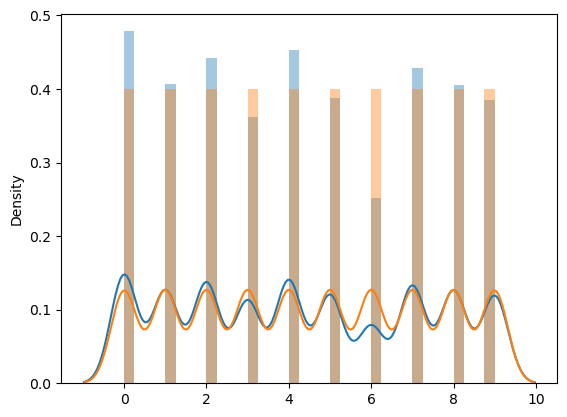

In [36]:
sns.distplot(y_pred)
sns.distplot(y_train)

10000
10000


<AxesSubplot:>

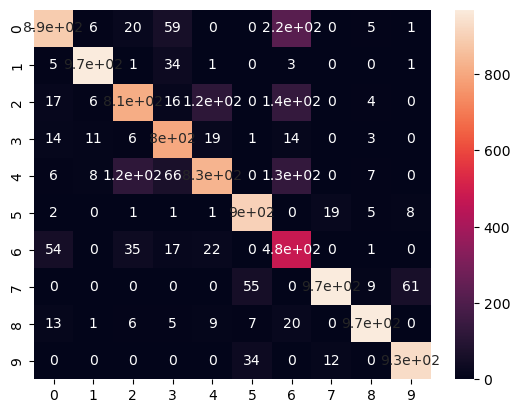

In [37]:
y_pred=FWNN.calculatetestPredClasses()
sns.heatmap(confusion_matrix(y_pred,y_test),annot=True)

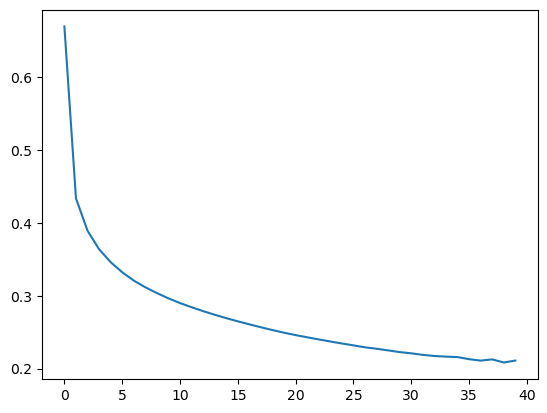

In [38]:
plt.plot(range(len(loss)),loss)